In [1]:
# Originally made by Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings)
# The original BigGAN+CLIP method was by https://twitter.com/advadnoun

import argparse
import math
import random
# from email.policy import default
from urllib.request import urlopen
from tqdm import tqdm
import sys
import os

# pip install taming-transformers doesn't work with Gumbel, but does not yet work with coco etc
# appending the path does work with Gumbel, but gives ModuleNotFoundError: No module named 'transformers' for coco etc
sys.path.append('taming-transformers')

from omegaconf import OmegaConf
from taming.models import cond_transformer, vqgan
#import taming.modules 

import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from torch.cuda import get_device_properties
torch.backends.cudnn.benchmark = False		# NR: True is a bit faster, but can lead to OOM. False is more deterministic.
#torch.use_deterministic_algorithms(True)	# NR: grid_sampler_2d_backward_cuda does not have a deterministic implementation

from torch_optimizer import DiffGrad, AdamP, RAdam

import torchvision
from torchvision import transforms
from torchvision.transforms import CenterCrop, Resize, ToTensor, Normalize
import numpy as np
from sklearn.decomposition import PCA

import kornia.augmentation as K
import numpy as np
import imageio

from PIL import ImageFile, Image, PngImagePlugin, ImageChops
ImageFile.LOAD_TRUNCATED_IMAGES = True

from subprocess import Popen, PIPE
import re

# Supress warnings
import warnings
warnings.filterwarnings('ignore')


# Check for GPU and reduce the default image size if low VRAM
default_image_size = 256

In [2]:

# Various functions and classes
def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))


def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()


def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]


# For zoom video
def zoom_at(img, x, y, zoom):
    w, h = img.size
    zoom2 = zoom * 2
    img = img.crop((x - w / zoom2, y - h / zoom2, 
                    x + w / zoom2, y + h / zoom2))
    return img.resize((w, h), Image.LANCZOS)


# NR: Testing with different intital images
def random_noise_image(w,h):
    random_image = Image.fromarray(np.random.randint(0,255,(w,h,3),dtype=np.dtype('uint8')))
    return random_image


# create initial gradient image
def gradient_2d(start, stop, width, height, is_horizontal):
    if is_horizontal:
        return np.tile(np.linspace(start, stop, width), (height, 1))
    else:
        return np.tile(np.linspace(start, stop, height), (width, 1)).T


def gradient_3d(width, height, start_list, stop_list, is_horizontal_list):
    result = np.zeros((height, width, len(start_list)), dtype=float)

    for i, (start, stop, is_horizontal) in enumerate(zip(start_list, stop_list, is_horizontal_list)):
        result[:, :, i] = gradient_2d(start, stop, width, height, is_horizontal)

    return result

    
def random_gradient_image(w,h):
    array = gradient_3d(w, h, (0, 0, np.random.randint(0,255)), (np.random.randint(1,255), np.random.randint(2,255), np.random.randint(3,128)), (True, False, False))
    random_image = Image.fromarray(np.uint8(array))
    return random_image


# Used in older MakeCutouts
def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size

    input = input.view([n * c, 1, h, w])

    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])

    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])

    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)


class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward

    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)

replace_grad = ReplaceGrad.apply


class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)

    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None

clamp_with_grad = ClampWithGrad.apply


def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)


class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow # not used with pooling
        
        # Pick your own augments & their order
        augment_list = []
        for item in args.augments[0]:
            if item == 'Ji':
                augment_list.append(K.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.7))
            elif item == 'Sh':
                augment_list.append(K.RandomSharpness(sharpness=0.3, p=0.5))
            elif item == 'Gn':
                augment_list.append(K.RandomGaussianNoise(mean=0.0, std=1., p=0.5))
            elif item == 'Pe':
                augment_list.append(K.RandomPerspective(distortion_scale=0.7, p=0.7))
            elif item == 'Ro':
                augment_list.append(K.RandomRotation(degrees=15, p=0.7))
            elif item == 'Af':
                augment_list.append(K.RandomAffine(degrees=15, translate=0.1, shear=5, p=0.7, padding_mode='zeros', keepdim=True)) # border, reflection, zeros
            elif item == 'Et':
                augment_list.append(K.RandomElasticTransform(p=0.7))
            elif item == 'Ts':
                augment_list.append(K.RandomThinPlateSpline(scale=0.8, same_on_batch=True, p=0.7))
            elif item == 'Cr':
                augment_list.append(K.RandomCrop(size=(self.cut_size,self.cut_size), pad_if_needed=True, padding_mode='reflect', p=0.5))
            elif item == 'Er':
                augment_list.append(K.RandomErasing(scale=(.1, .4), ratio=(.3, 1/.3), same_on_batch=True, p=0.7))
            elif item == 'Re':
                augment_list.append(K.RandomResizedCrop(size=(self.cut_size,self.cut_size), scale=(0.1,1),  ratio=(0.75,1.333), cropping_mode='resample', p=0.5))
                
        self.augs = nn.Sequential(*augment_list)
        self.noise_fac = 0.1
        # self.noise_fac = False

        # Uncomment if you like seeing the list ;)
        # print(augment_list)
        
        # Pooling
        self.av_pool = nn.AdaptiveAvgPool2d((self.cut_size, self.cut_size))
        self.max_pool = nn.AdaptiveMaxPool2d((self.cut_size, self.cut_size))

    def forward(self, input):
        cutouts = []
        
        for _ in range(self.cutn):            
            # Use Pooling
            cutout = (self.av_pool(input) + self.max_pool(input))/2
            cutouts.append(cutout)
            
        batch = self.augs(torch.cat(cutouts, dim=0))
        
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch


# An updated version with Kornia augments and pooling (where my version started):
class MakeCutoutsPoolingUpdate(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow # Not used with pooling

        self.augs = nn.Sequential(
            K.RandomAffine(degrees=15, translate=0.1, p=0.7, padding_mode='border'),
            K.RandomPerspective(0.7,p=0.7),
            K.ColorJitter(hue=0.1, saturation=0.1, p=0.7),
            K.RandomErasing((.1, .4), (.3, 1/.3), same_on_batch=True, p=0.7),            
        )
        
        self.noise_fac = 0.1
        self.av_pool = nn.AdaptiveAvgPool2d((self.cut_size, self.cut_size))
        self.max_pool = nn.AdaptiveMaxPool2d((self.cut_size, self.cut_size))

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        
        for _ in range(self.cutn):
            cutout = (self.av_pool(input) + self.max_pool(input))/2
            cutouts.append(cutout)
            
        batch = self.augs(torch.cat(cutouts, dim=0))
        
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch


# An Nerdy updated version with selectable Kornia augments, but no pooling:
class MakeCutoutsNRUpdate(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow
        self.noise_fac = 0.1
        
        # Pick your own augments & their order
        augment_list = []
        for item in args.augments[0]:
            if item == 'Ji':
                augment_list.append(K.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.7))
            elif item == 'Sh':
                augment_list.append(K.RandomSharpness(sharpness=0.3, p=0.5))
            elif item == 'Gn':
                augment_list.append(K.RandomGaussianNoise(mean=0.0, std=1., p=0.5))
            elif item == 'Pe':
                augment_list.append(K.RandomPerspective(distortion_scale=0.5, p=0.7))
            elif item == 'Ro':
                augment_list.append(K.RandomRotation(degrees=15, p=0.7))
            elif item == 'Af':
                augment_list.append(K.RandomAffine(degrees=30, translate=0.1, shear=5, p=0.7, padding_mode='zeros', keepdim=True)) # border, reflection, zeros
            elif item == 'Et':
                augment_list.append(K.RandomElasticTransform(p=0.7))
            elif item == 'Ts':
                augment_list.append(K.RandomThinPlateSpline(scale=0.8, same_on_batch=True, p=0.7))
            elif item == 'Cr':
                augment_list.append(K.RandomCrop(size=(self.cut_size,self.cut_size), pad_if_needed=True, padding_mode='reflect', p=0.5))
            elif item == 'Er':
                augment_list.append(K.RandomErasing(scale=(.1, .4), ratio=(.3, 1/.3), same_on_batch=True, p=0.7))
            elif item == 'Re':
                augment_list.append(K.RandomResizedCrop(size=(self.cut_size,self.cut_size), scale=(0.1,1),  ratio=(0.75,1.333), cropping_mode='resample', p=0.5))
                
        self.augs = nn.Sequential(*augment_list)


    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
        batch = self.augs(torch.cat(cutouts, dim=0))
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch


# An updated version with Kornia augments, but no pooling:
class MakeCutoutsUpdate(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow
        self.augs = nn.Sequential(
            K.RandomHorizontalFlip(p=0.5),
            K.ColorJitter(hue=0.01, saturation=0.01, p=0.7),
            # K.RandomSolarize(0.01, 0.01, p=0.7),
            K.RandomSharpness(0.3,p=0.4),
            K.RandomAffine(degrees=30, translate=0.1, p=0.8, padding_mode='border'),
            K.RandomPerspective(0.2,p=0.4),)
        self.noise_fac = 0.1


    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
        batch = self.augs(torch.cat(cutouts, dim=0))
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch


# This is the original version (No pooling)
class MakeCutoutsOrig(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
        return clamp_with_grad(torch.cat(cutouts, dim=0), 0, 1)


def load_vqgan_model(config_path, checkpoint_path):
    global gumbel
    gumbel = False
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.vqgan.GumbelVQ':
        model = vqgan.GumbelVQ(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
        gumbel = True
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model


def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)



In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vqgan = load_vqgan_model('checkpoints/vqgan_imagenet_f16_16384.yaml', 'checkpoints/vqgan_imagenet_f16_16384.ckpt').to(device)
jit = True if float(torch.__version__[:3]) < 1.8 else False
#perceptor = clip.load('ViT-B/32', jit=jit)[0].eval().requires_grad_(False).to(device)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from checkpoints/vqgan_imagenet_f16_16384.ckpt


In [6]:
def process_folder(folder_name):
    
    
    folder_files = os.listdir(folder_name)
    folder_tensors = torch.vstack([preprocess(Image.open(folder_name + folder_file)).unsqueeze(0).to(device) for folder_file in folder_files])
    return folder_tensors

preprocess = torchvision.transforms.Compose(
   [Resize(size=224),
    CenterCrop(size=(224, 224)),
    ToTensor(),
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))]
)
artist_a = process_folder("data/tyrus/")[:]
artist_b = process_folder("data/rothko/")[:]
artist_c = process_folder("data/joseon/")[:]

In [10]:

#between 0 and 1
def normalize(vector, zero_center=True):
    zero_center_vector =  vector - vector.min()
    change_vector_spread = zero_center_vector / (zero_center_vector.max() - zero_center_vector.min())
    if not zero_center:
        return change_vector_spread
    else:
        return  (change_vector_spread * 2) - 1
def normalize_batch(artist_samples):
    return torch.stack([normalize(artist_sample) for artist_sample in artist_samples])

In [11]:
folders = ["data/tyrus/", "data/rothko/","data/joseon/"]

# sizes = [len(os.listdir(data_path)) for data_path in folders]
num_samples = 5
sizes = [num_samples for data_path in folders]

In [100]:

class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow # not used with pooling
        
        # Pick your own augments & their order
        augment_list = []
        
        self.augs = nn.Sequential(*augment_list)
        self.noise_fac = 0.1
        # self.noise_fac = False

        # Uncomment if you like seeing the list ;)
        # print(augment_list)
        
        # Pooling
        self.av_pool = nn.AdaptiveAvgPool2d((self.cut_size, self.cut_size))
        self.max_pool = nn.AdaptiveMaxPool2d((self.cut_size, self.cut_size))

    def forward(self, input):
        cutouts = []
        
        for _ in range(self.cutn):            
            # Use Pooling
            cutout = (self.av_pool(input) + self.max_pool(input))/2
            cutouts.append(cutout)
            
        batch = self.augs(torch.cat(cutouts, dim=0))
        
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch


In [98]:
from CLIP import clip
import PIL

perceptor = clip.load('ViT-B/32', jit=jit)[0].eval().requires_grad_(False).to(device)
cut_size = perceptor.visual.input_resolution
make_cutouts = MakeCutouts(cut_size, cutn=32)

In [97]:

processed_images = [process_folder(data_path)[:num_samples] for data_path in folders]
normalized_images = torch.vstack([normalize_batch(artist_sample) for artist_sample in processed_images])
encoded_z, *_ = vqgan.encode((normalized_images).to(device))


In [327]:
def vector_quantize_noise_edit(x, codebook, noise=True, noise_amount=0.001, patch_i=0, patch_j=0,normal=True ):
    #Squares and sums along the last dimension, adds codebook squared and summed 
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    if noise and normal:
        noise = torch.zeros(x_q.shape)
        noise = torch.normal(0,100, size=noise.shape)
        #noise[:,patch_i,patch_j,:]+= noise_amount
        x_q_edit = x_q + noise.cuda()
    return replace_grad(x_q, x), replace_grad(x_q_edit,x)

def vector_quantize_noise_normal(x, codebook, noise_mean, noise_std, dim=0):
    #Squares and sums along the last dimension, adds codebook squared and summed 
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    noise = torch.zeros(x_q.shape)
    
    noise[:,:,:,dim] = torch.normal(noise_mean,noise_std, size=(x_q.shape[0], x_q.shape[1], x_q.shape[2]))

    x_q_edit = x_q + noise.cuda()
    return replace_grad(x_q, x), replace_grad(x_q_edit,x)

In [ ]:
def get_concat_h_repeat(im, column):
    dst = Image.new('RGB', (im.width * column, im.height))
    for x in range(column):
        dst.paste(im, (x * im.width, 0))
    return dst

def get_concat_v_repeat(im, row):
    dst = Image.new('RGB', (im.width, im.height * row))
    for y in range(row):
        dst.paste(im, (0, y * im.height))
    return dst

def get_concat_tile_repeat(im, row, column):
    dst_h = get_concat_h_repeat(im, column)
    return get_concat_v_repeat(dst_h, row)

im_s = im1.resize((im1.width // 2, im1.height // 2))
get_concat_tile_repeat(im_s, 3, 4).save('data/dst/pillow_concat_tile_repeat.jpg')


In [ ]:
def concat_images_w(images, num_images=6, im_width=256,im_height=256):
    dst = Image.new('RGB', (im_width * num_images, im_height))
    [dst.paste(images[image_idx], (image_idx * im_width, 0)) for image_idx in range(len(images))]
    return dst

def concat_images_h(images, num_rows=6, im_width=4096,im_height=256):
    dst = Image.new('RGB', (im_width, num_rows* im_height))
    [dst.paste(images[image_idx], (0, image_idx*im_height)) for image_idx in range(len(images))]
    return dst


In [399]:
images = []
for i in range(256):
    vq_z,vq_edit = vector_quantize_noise_normal(encoded_z.movedim(1, 3), vqgan.quantize.embedding.weight, noise_mean=25, noise_std=10, dim=i)

    #vq_z,vq_edit = vector_quantize_noise_normal(encoded_z.movedim(1, 3), vqgan.quantize.embedding.weight, noise_amount=1, patch_i=2, patch_j=2)
    vq_z,vq_edit = vq_z.movedim(3, 1), vq_edit.movedim(3,1)

    decoded = clamp_with_grad(vqgan.decode(vq_edit).add(1).div(2), 0, 1)[2]
    #decoded = clamp_with_grad(vqgan.decode(vq_edit).add(1).div(2), 0, 1)[3]
    image_numpy = decoded.view(224,224,3).cpu().detach().numpy()

    image_numpy = decoded.cpu().movedim(0,2)
    maximized = PIL.Image.fromarray(np.uint8(image_numpy*255)) 
    maximized.save(f'animation_steps/{i}.jpg')
    images.append(maximized)
# PIL.Image.fromarray(np.uint8(image_numpy*255))
# normalize(make_cutouts(decoded)).shape

In [400]:
!cd animation steps
!ffmpeg -f image2 -i %d.jpg tyrus_25_10_out.gif

/bin/sh: 1: cd: can't cd to animation
ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/root/anaconda3/envs/replearn --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.

In [380]:
rows = concat_images_h([concat_images(images[idx:idx+16],num_images=16) for idx in  range(0,256,16)], num_rows=16)

In [381]:
rows.save("im2_mean10_std10_continuouspalette_alldim.jpg")

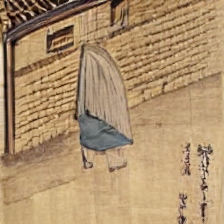

In [368]:
images[0]